***Import Libraries***

In [234]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import re
import string
import spacy
import time
import warnings
import seaborn as sns
from spacy import displacy
Text_Visualization = spacy.load('en_core_web_sm')
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob
%pip install emoji
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from yellowbrick.cluster import KElbowVisualizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [16, 10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Read Dataset**

In [235]:
df= pd.read_csv("/content/Tweets.csv")
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different flight to Chicago.,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


**Plot Airlines**

<Axes: ylabel='airline'>

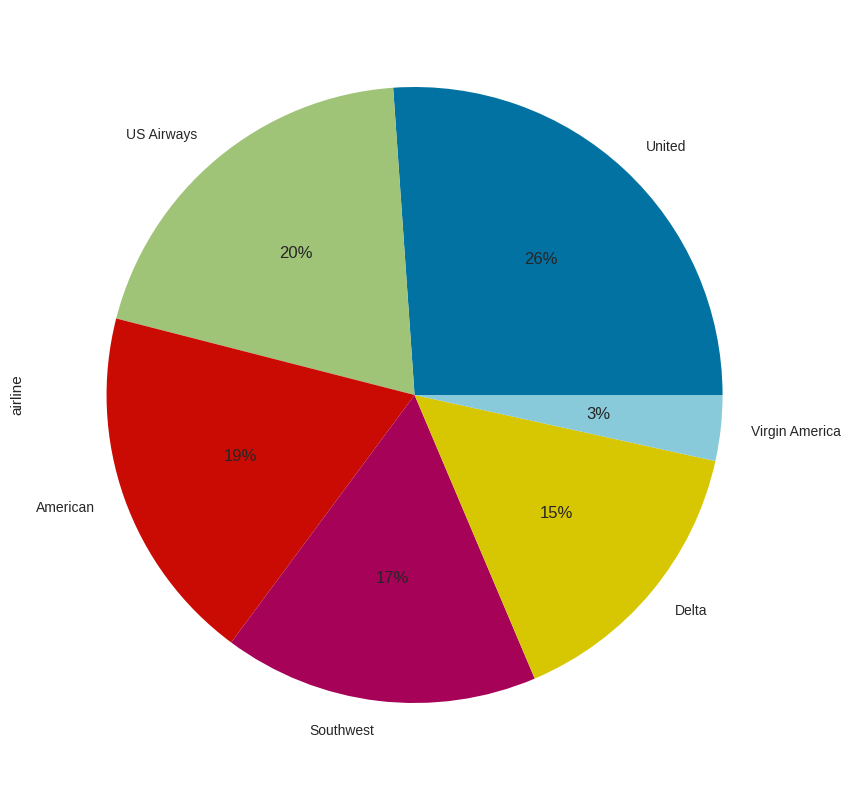

In [283]:
df.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

<Axes: ylabel='airline_sentiment'>

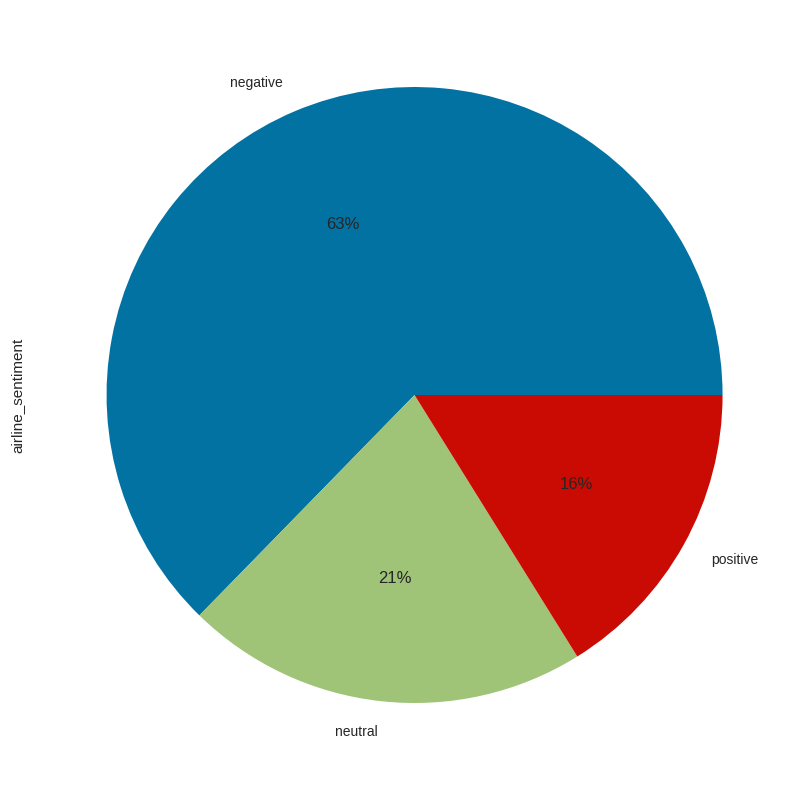

In [286]:
df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

**Plot Labels(positive, negative and neutral)**

**Dataset Shape**

In [236]:
df.shape

(14640, 15)

**Dataset Columns**

In [237]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

**Get Columns With NaN Values**

In [238]:
cols_with_nan = df.columns[df.isna().any()].tolist()
print(cols_with_nan)

['negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'tweet_location', 'user_timezone']


**Drop Columns With NaN Values**

In [239]:
df = df.dropna(axis=1)
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800
...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800


**Dataset Shape After Drop Columns With NaN Values**

In [240]:
df.shape

(14640, 8)

**Drop Duplicates**

In [241]:
df.drop_duplicates
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800
...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800


In [242]:
df.shape

(14640, 8)

**Dataset Description**

In [243]:
df.describe()

,tweet_id,airline_sentiment_confidence,retweet_count
count,1.464000e+04,14640.000000,14640.000000
mean,5.692184e+17,0.900169,0.082650
std,7.791112e+14,0.162830,0.745778
min,5.675883e+17,0.335000,0.000000
25%,5.685592e+17,0.692300,0.000000
50%,5.694779e+17,1.000000,0.000000
75%,5.698905e+17,1.000000,0.000000
max,5.703106e+17,1.000000,44.000000


**Dataset Information**

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   airline                       14640 non-null  object 
 4   name                          14640 non-null  object 
 5   retweet_count                 14640 non-null  int64  
 6   text                          14640 non-null  object 
 7   tweet_created                 14640 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 915.1+ KB


**Dataset Data Types**

In [245]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
airline                          object
name                             object
retweet_count                     int64
text                             object
tweet_created                    object
dtype: object

**Make New Column Called "Results" and Lower The Text**

In [246]:
df['results'] = df['text'].str.lower()
display(df)

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,@virginamerica what @dhepburn said.
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,@virginamerica plus you've added commercials to the experience... tacky.
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,@virginamerica i didn't today... must mean i need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,@virginamerica and it's a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,@americanair thank you we got on a different flight to chicago.
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,@americanair leaving over 20 minutes late flight. no warnings or communication until we were 15 minutes late flight. that's called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,@americanair please bring american airlines to #blackberry10
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"@americanair you have my money, you change my flight, and don't answer your phones! any other suggestions so i can make my commitment??"


**Remove Repeating Characters**

In [247]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1\1+', r'\1\1', text)
df['results'] = df['results'].apply(lambda x: remove_repeating_char(x))
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,@virginamerica what @dhepburn said.
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,@virginamerica plus you've added commercials to the experience.. tacky.
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,@virginamerica i didn't today.. must mean i need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,@virginamerica and it's a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,@americanair thank you we got on a different flight to chicago.
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,@americanair leaving over 20 minutes late flight. no warnings or communication until we were 15 minutes late flight. that's called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,@americanair please bring american airlines to #blackberry10
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"@americanair you have my money, you change my flight, and don't answer your phones! any other suggestions so i can make my commitment??"


**Remove Mentions**

In [248]:
def remove_mentions(text):
    return re.sub(r'@[A-Za-z0-9_]+', r' ', text)
df['results'] = df['results'].apply(lambda x: remove_mentions(x))
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,what said.
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,plus you've added commercials to the experience.. tacky.
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,i didn't today.. must mean i need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,and it's a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,thank you we got on a different flight to chicago.
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,leaving over 20 minutes late flight. no warnings or communication until we were 15 minutes late flight. that's called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,please bring american airlines to #blackberry10
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"you have my money, you change my flight, and don't answer your phones! any other suggestions so i can make my commitment??"


**Remove Hashtags**

In [249]:
def remove_hashtag(text):
    return re.sub(r'#[A-Za-z0-9_]+', r' ', text)
df['results'] = df['results'].apply(lambda x: remove_hashtag(x))
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,what said.
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,plus you've added commercials to the experience.. tacky.
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,i didn't today.. must mean i need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,and it's a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,thank you we got on a different flight to chicago.
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,leaving over 20 minutes late flight. no warnings or communication until we were 15 minutes late flight. that's called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,please bring american airlines to
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"you have my money, you change my flight, and don't answer your phones! any other suggestions so i can make my commitment??"


**Remove Links**

In [250]:
def remove_links(text):
    return re.sub(r'http\S+|www.\S+|<.*?>', r' ', text)
df['results'] = df['results'].apply(lambda x: remove_links(x))
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,what said.
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,plus you've added commercials to the experience.. tacky.
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,i didn't today.. must mean i need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,and it's a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,thank you we got on a different flight to chicago.
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,leaving over 20 minutes late flight. no warnings or communication until we were 15 minutes late flight. that's called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,please bring american airlines to
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"you have my money, you change my flight, and don't answer your phones! any other suggestions so i can make my commitment??"


**Demojize The Emojies**

In [251]:
df['results'] = df['results'].apply(lambda x: emoji.demojize(x,language='es'))
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,what said.
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,plus you've added commercials to the experience.. tacky.
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,i didn't today.. must mean i need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,and it's a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,thank you we got on a different flight to chicago.
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,leaving over 20 minutes late flight. no warnings or communication until we were 15 minutes late flight. that's called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,please bring american airlines to
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"you have my money, you change my flight, and don't answer your phones! any other suggestions so i can make my commitment??"


**Remove Punctuation**

In [252]:
def remove_punctuation(punc):
    for char in string.punctuation:
        punc = punc.replace(char, ' ')
    return punc
df['results'] = df['results'].apply(remove_punctuation)
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,what said
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,plus you ve added commercials to the experience tacky
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,i didn t today must mean i need to take another trip
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,it s really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,and it s a really big bad thing about it
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,thank you we got on a different flight to chicago
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,leaving over 20 minutes late flight no warnings or communication until we were 15 minutes late flight that s called shitty customer svc
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,please bring american airlines to
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,you have my money you change my flight and don t answer your phones any other suggestions so i can make my commitment


**Tokenization**

In [253]:
df['results'] = df['results'].apply(lambda x: word_tokenize(x))
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,"[what, said]"
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,"[plus, you, ve, added, commercials, to, the, experience, tacky]"
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,"[i, didn, t, today, must, mean, i, need, to, take, another, trip]"
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"[it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, amp, they, have, little, recourse]"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,"[and, it, s, a, really, big, bad, thing, about, it]"
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,"[thank, you, we, got, on, a, different, flight, to, chicago]"
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,"[leaving, over, 20, minutes, late, flight, no, warnings, or, communication, until, we, were, 15, minutes, late, flight, that, s, called, shitty, customer, svc]"
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,"[please, bring, american, airlines, to]"
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"[you, have, my, money, you, change, my, flight, and, don, t, answer, your, phones, any, other, suggestions, so, i, can, make, my, commitment]"


**Remove Stopwords**

In [254]:
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS
df['results']= df['results'].apply(lambda x: [item for item in x if item not in stop_words])
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,results
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,[said]
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,"[plus, ve, added, commercials, experience, tacky]"
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,"[didn, t, today, mean, need, trip]"
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,"[s, really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse]"
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,"[s, really, big, bad, thing]"
...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different flight to Chicago.,2015-02-22 12:01:01 -0800,"[thank, got, different, flight, chicago]"
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,2015-02-22 11:59:46 -0800,"[leaving, 20, minutes, late, flight, warnings, communication, 15, minutes, late, flight, s, called, shitty, customer, svc]"
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to #BlackBerry10,2015-02-22 11:59:15 -0800,"[bring, american, airlines]"
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",2015-02-22 11:59:02 -0800,"[money, change, flight, don, t, answer, phones, suggestions, make, commitment]"


In [255]:
type(df.results.values)

numpy.ndarray

In [256]:
type(df.text)

pandas.core.series.Series

**TF-IDF Featrue Extraction**

In [263]:
vec = TfidfVectorizer(stop_words="english")

vec.fit(df.text.values)
features = vec.transform(df.results.values)

TfidfVectorizer(stop_words='english')

In [266]:
features.shape

(14640, 14770)

**Split Data Into Training and Testing**

In [288]:
X = features
ylabels = df['airline_sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=0)

**Apply SVM**

In [287]:
from sklearn.svm import LinearSVC
svm_classifier = LinearSVC()
svm_classifier.fit(X_train, y_train)

LinearSVC()

**predictions**

In [289]:
predictions = svm_classifier.predict(X_test)


**confusion_matrix**

In [290]:
print(confusion_matrix(y_test,predictions))


[[1870    0    0]
 [ 614    0    0]
 [ 444    0    0]]


**classification_report**

In [291]:
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

    negative       0.64      1.00      0.78      1870
     neutral       0.00      0.00      0.00       614
    positive       0.00      0.00      0.00       444

    accuracy                           0.64      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.41      0.64      0.50      2928



**accuracy_score**

In [292]:
print(accuracy_score(y_test, predictions))

0.6386612021857924


**Sentence To Test All Functions**

In [293]:
sentence= '''I am Abdo Gnesh, Student at Faculty of Computer and Artificial Intelligence, Cairo University...and here is my linkedin profile: (https://linkedin.com/in/abdelrahmanmohamed-sayed-21229a247
) and my Githup profile: (https://github.com/AbdelrhmanMohamed2001
) @abdo #Gnesh ssss'''

In [294]:
a= remove_repeating_char(sentence)
a

'I am Abdo Gnesh, Student at Faculty of Computer and Artificial Intelligence, Cairo University..and here is my linkedin profile: (https://linkedin.com/in/abdelrahmanmohamed-sayed-21229a247\n) and my Githup profile: (https://github.com/AbdelrhmanMohamed2001\n) @abdo #Gnesh ss'

In [295]:
b= remove_mentions(a)
b

'I am Abdo Gnesh, Student at Faculty of Computer and Artificial Intelligence, Cairo University..and here is my linkedin profile: (https://linkedin.com/in/abdelrahmanmohamed-sayed-21229a247\n) and my Githup profile: (https://github.com/AbdelrhmanMohamed2001\n)   #Gnesh ss'

In [276]:
c=remove_links(b)
c

'I am Abdo Gnesh, Student at Faculty of Computer and Artificial Intelligence, Cairo University..and here is my linkedin profile: ( \n) and my Githup profile: ( \n)   #Gnesh ss'

In [277]:
d=remove_punctuatuion(c)
d

'I am Abdo Gnesh Student at Faculty of Computer and Artificial Intelligence Cairo Universityand here is my linkedin profile  \n and my Githup profile  \n   Gnesh ss'

In [278]:
e=remove_hashtag(d)
e

'I am Abdo Gnesh Student at Faculty of Computer and Artificial Intelligence Cairo Universityand here is my linkedin profile  \n and my Githup profile  \n   Gnesh ss'

In [279]:
f= word_tokenize(e)
f

['I',
 'am',
 'Abdo',
 'Gnesh',
 'Student',
 'at',
 'Faculty',
 'of',
 'Computer',
 'and',
 'Artificial',
 'Intelligence',
 'Cairo',
 'Universityand',
 'here',
 'is',
 'my',
 'linkedin',
 'profile',
 'and',
 'my',
 'Githup',
 'profile',
 'Gnesh',
 'ss']

In [280]:

for item in f:
   if item not in stop_words:
    print(item)


I
Abdo
Gnesh
Student
Faculty
Computer
Artificial
Intelligence
Cairo
Universityand
linkedin
profile
Githup
profile
Gnesh
ss
